# Predictive Policing in San Francisco, SF
Using crime data set in SF in 2016 creates the model for predicting it in 2017.

## For a blog post explaining the motivation behind this project and an interactive map with the predictions visit:

 1. http://www.orlandotorres.org/predictive-policing-sf.html
 2. data, [opendata](https://datasf.org/opendata/) or github
 3. get data
    - from the coposition of colab hosted on google drive:
       1. Click on the three dots visible when you hover above the directory
       2. Select the “upload” option.
       3. 3. Select the file(s) you wish to upload from the “File Upload” dialog window.
       4. Wait for the upload to complete. The upload progress is shown at the bottom of the file-explorer pane.
    - get from  Google drive
      1. run
         ```
         from google.colab import drive
         drive.mount('/content/gdrive')
         ```
      2. login and get the files    
4. python avails robost system but not all packages which involve and are developed ny themselves; we can remove the warning the messages whoch come from the inconsistenebce of packages:
```
import warnings
warnings.filterwarnings("ignore")
```


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
ls gdrive/MyDrive/2023/2023-2-Python-AI

crime_sf.ipynb  data/  imgs/  Llama2OnColab.ipynb  Week-17-18-CNN.ipynb


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# install if necessary
!pip install geopandas shapely

In [61]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.1 MB/s eta 0:00:00


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
$ if upladed in the sub-folder, data, or on the run on local
crime17 = pd.read_csv('data/sf_incidents17.csv')
crime16 = pd.read_csv('data/sf_incidents16.csv')

In [14]:
# if on the google dvive
crime17 = pd.read_csv('gdrive/MyDrive/2023/2023-2-Python-AI/data/sf_incidents17.csv')
crime16 = pd.read_csv('gdrive/MyDrive/2023/2023-2-Python-AI/data/sf_incidents16.csv')

### Find the zip codes for each incident given the latitude and longitude

In [15]:
crime16['geometry'] = crime16.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [16]:
geo_police_data = geopandas.GeoDataFrame(crime16, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [18]:
sf = geopandas.read_file('gdrive/MyDrive/2023/2023-2-Python-AI/data/zipcodes_geo.json')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

In [19]:
crime16 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [20]:
day_time_zip_16 = crime16[['Date', 'DayOfWeek', 'Time', 'zip']]

In [21]:
day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['Date'])

day_time_zip_16.loc[:, 'Hour'] = pd.to_datetime(day_time_zip_16['Time'])
day_time_zip_16.loc[:, 'Hour'] = day_time_zip_16.Hour.apply(lambda x: x.hour)

In [22]:
day_time_zip_16.head()

,Date,DayOfWeek,Time,zip,Hour
0,2016-01-29,Friday,11:00,94103,11
1,2016-01-29,Friday,11:00,94103,11
2,2016-02-18,Thursday,22:00,94109,22
3,2016-10-03,Monday,01:18,94102,1
4,2016-04-25,Monday,14:59,94124,14


## Remove data from November and December because I don't have that data for 2017 to compare it to

First convert the object to datetime format:

In [23]:
day_time_zip_16['Date']=pd.to_datetime(day_time_zip_16['Date'])

In [24]:
day_time_zip_16_final = day_time_zip_16[day_time_zip_16.Date.dt.month < 11]

In [25]:
day_time_zip_16.head()

,Date,DayOfWeek,Time,zip,Hour
0,2016-01-29,Friday,11:00,94103,11
1,2016-01-29,Friday,11:00,94103,11
2,2016-02-18,Thursday,22:00,94109,22
3,2016-10-03,Monday,01:18,94102,1
4,2016-04-25,Monday,14:59,94124,14


## Combine all the crimes into hours and days and zip codes

In [26]:
day_time_zip_16_final = day_time_zip_16[['DayOfWeek', 'zip', 'Hour']]

In [27]:
day_time_zip_16_final.loc[:, 'Crimes'] = 1

In [28]:
hour_totals_16 = day_time_zip_16_final.groupby(['DayOfWeek', 'zip', 'Hour']).sum().reset_index()

In [29]:
hour_totals_16.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
41,Friday,94103,17,265
650,Monday,94103,17,258
2482,Thursday,94103,18,257
3699,Wednesday,94103,18,257
42,Friday,94103,18,253


## Create dummy variables to start doing analysis

In [30]:
hour_totals_16 = hour_totals_16[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [31]:
totals_dummies_16 = pd.get_dummies(hour_totals_16)

In [32]:
X_16 = totals_dummies_16.iloc[:, 1:]
y_16 = totals_dummies_16.iloc[:, 0]

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
model = LinearRegression()
model.fit(X_16,y_16)


LinearRegression()

In [35]:
# predictions = model.predict(X_new)
model.coef_, model.intercept_

(array([  1.4119033 ,   3.10317784,  -1.09658212,   1.09743928,
         -2.09902395,  -0.23872888,  -0.47961383,  -0.28666834,
         56.89681362, 109.9325279 , -30.00936583, -15.20437686,
          9.03371838, -11.6924721 ,  31.24800409,  47.19443266,
        -17.05253415,   5.38490886,  -5.04366257,   3.34919457,
        -18.27192051,  -0.78175781, -10.62104353, -15.06513666,
         -6.07937686, -12.7110121 ,  16.87300409, -27.4460184 ,
        -33.34995952, -21.91906869, -15.29366257,   3.84324219,
        -13.23443667, -29.98004153]),
 18.235346075949188)

**Exercise**, you can predict the result as new feature

## Linear Regression with 2016 data

In [36]:
linear_regression =  LinearRegression()

results = linear_regression.fit(X_16,y_16)

In [37]:
results

LinearRegression()

# Test it with new 2017 data

### Find the zip codes for each incident given the latitude and longitude

In [38]:
crime17['geometry'] = crime17.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [39]:
geo_police_data = geopandas.GeoDataFrame(crime17, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [41]:
sf = geopandas.read_file('gdrive/MyDrive/2023/2023-2-Python-AI/data/zipcodes_geo.json')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

In [42]:
crime17 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [43]:
day_time_zip_17 = crime17[['DayOfWeek', 'Time', 'zip']]

In [44]:
day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time'])
day_time_zip_17['Hour'] = day_time_zip_17.Hour.apply(lambda x: x.hour)

## Combine all the crimes into hours and days and zip codes

In [45]:
day_time_zip_17 = day_time_zip_17[['DayOfWeek', 'zip', 'Hour']]

In [46]:
day_time_zip_17['Crimes'] = 1

In [47]:
hour_totals_17 = day_time_zip_17.groupby(['DayOfWeek', 'zip', 'Hour']).count().reset_index()

In [48]:
hour_totals_17.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
2465,Thursday,94103,18,227
2466,Thursday,94103,19,220
41,Friday,94103,17,213
3067,Tuesday,94103,18,213
44,Friday,94103,20,201


## Create dummy variables to start doing analysis

In [49]:
hour_totals_17 = hour_totals_17[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [50]:
totals_dummies_17 = pd.get_dummies(hour_totals_17)

In [51]:
X_17 = totals_dummies_17.iloc[:, 1:]
y_17 = totals_dummies_17.iloc[:, 0]

# Testing the different models

## Linear Regression

In [52]:
linear_regression =  LinearRegression()
results = linear_regression.fit(X_16,y_16)

In [53]:
y_pred=results.predict(X_17)

In [54]:
from sklearn.metrics import r2_score
r2_score(y_17, y_pred)

0.6386917837250609

## Random Forest

In [55]:
rf = RandomForestRegressor()
rf.fit(X_16, y_16)
rf.score(X_17,y_17)

0.8086511098558319

In [56]:
list(zip(X_16.columns, rf.feature_importances_))

[('Hour', 0.2436481641948516),
 ('DayOfWeek_Friday', 0.00713262324889825),
 ('DayOfWeek_Monday', 0.0038444336753977212),
 ('DayOfWeek_Saturday', 0.008519663482191301),
 ('DayOfWeek_Sunday', 0.009171229437311303),
 ('DayOfWeek_Thursday', 0.004219275796135047),
 ('DayOfWeek_Tuesday', 0.003679613091052193),
 ('DayOfWeek_Wednesday', 0.0047281845648098715),
 ('zip_94102', 0.10773528675013778),
 ('zip_94103', 0.3558068490990321),
 ('zip_94104', 0.007226758851033311),
 ('zip_94105', 0.0009243845166265625),
 ('zip_94107', 0.013547948385352802),
 ('zip_94108', 0.0008903577177570353),
 ('zip_94109', 0.04714913840760687),
 ('zip_94110', 0.08420842767636955),
 ('zip_94111', 0.0005412262021542052),
 ('zip_94112', 0.01129841143324335),
 ('zip_94114', 0.0026417279693903627),
 ('zip_94115', 0.01012823420209864),
 ('zip_94116', 0.0006704796764091334),
 ('zip_94117', 0.007611743493892374),
 ('zip_94118', 0.0009338453867817189),
 ('zip_94121', 0.00047571390247952693),
 ('zip_94122', 0.002536893831306627)

## KNN

In [57]:
knn = KNeighborsRegressor()
knn.fit(X_16, y_16)
knn.score(X_17,y_17)

0.7327464545918523

## SVM

In [58]:
svm = SVR()
svm.fit(X_16, y_16)
svm.score(X_17,y_17)

0.13401392445832772

## XGBoost

In [59]:
xgb = XGBRegressor()
xgb.fit(X_16, y_16)
xgb.score(X_17,y_17)

0.8146436419430099

**CatBoost**

In [65]:
cat = CatBoostRegressor()
cat.fit(X_16, y_16)
cat.score(X_17,y_17)

Learning rate set to 0.051482
0:	learn: 35.9309202	total: 55ms	remaining: 55s
1:	learn: 34.7746075	total: 59.5ms	remaining: 29.7s
2:	learn: 33.6973683	total: 72.3ms	remaining: 24s
3:	learn: 32.4960209	total: 77.2ms	remaining: 19.2s
4:	learn: 31.4350905	total: 82.6ms	remaining: 16.4s
5:	learn: 30.3989473	total: 89.1ms	remaining: 14.8s
6:	learn: 29.5583893	total: 94.4ms	remaining: 13.4s
7:	learn: 28.6919027	total: 98.8ms	remaining: 12.3s
8:	learn: 27.9463319	total: 104ms	remaining: 11.5s
9:	learn: 27.1846296	total: 109ms	remaining: 10.8s
10:	learn: 26.4076974	total: 114ms	remaining: 10.3s
11:	learn: 25.6885258	total: 119ms	remaining: 9.82s
12:	learn: 25.0593144	total: 124ms	remaining: 9.39s
13:	learn: 24.5090288	total: 128ms	remaining: 9.04s
14:	learn: 23.9101486	total: 133ms	remaining: 8.73s
15:	learn: 23.4456841	total: 135ms	remaining: 8.31s
16:	learn: 22.9838832	total: 140ms	remaining: 8.07s
17:	learn: 22.5444350	total: 144ms	remaining: 7.85s
18:	learn: 22.0782207	total: 148ms	remaini

0.8272315794585562

## MLP Regressor

In [66]:
mlp = MLPRegressor(hidden_layer_sizes = (100,100,100,100), random_state=444)
mlp.fit(X_16,y_16)

MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), random_state=444)

In [67]:
mlp.score(X_17, y_17)

0.8231209796331261

## Combine predictions and actual results into one dataframe

In [68]:
mlp_predicts = mlp.predict(X_16)

In [69]:
xgb_predicts = xgb.predict(X_16)

In [70]:
hour_totals_17['Predicted_mlp'] = pd.Series(mlp_predicts)
hour_totals_17['Predicted_xgb'] = pd.Series(xgb_predicts)

### Divide by 365 to get the number of crime incidents each day

In [71]:
hour_totals_17['Crimes'] = hour_totals_17['Crimes']/365
hour_totals_17['Predicted_mlp'] = hour_totals_17['Predicted_mlp']/365
hour_totals_17['Predicted_xgb'] = hour_totals_17['Predicted_xgb']/365


In [72]:
hour_totals_17 = np.round(hour_totals_17,2)

In [74]:
hour_totals_17.to_json("gdrive/MyDrive/2023/2023-2-Python-AI/data/crime_predictions.json", orient='records', double_precision=2)

## Create a quick Chloropleth map as a sanity check

In [75]:
chloropleth_data = hour_totals_17.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

<Axes: >

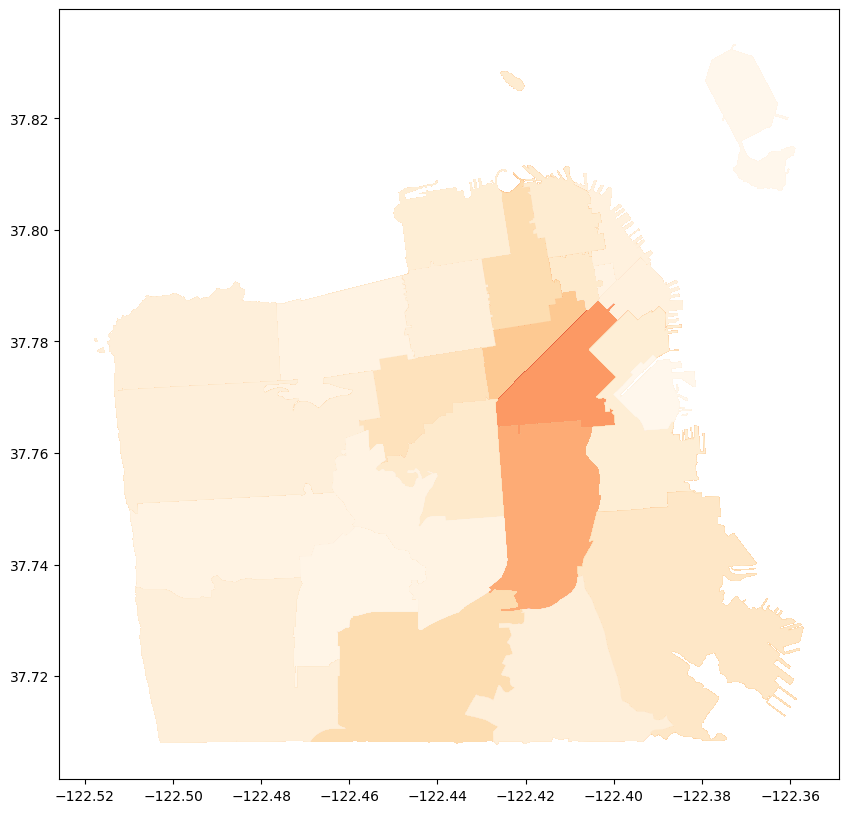

In [76]:
chloropleth_data.plot(column='Crimes', cmap='OrRd', figsize=(13,10))

### Notes
1. different scores, for diffenent models
2. the scores could be arisen if tuning the parameters do.
3. Useg less-code, pycaret.

In [ ]:
from pycaret.regression import *
# ...

